Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
%matplotlib inline

C:\Users\frank\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\frank\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\frank\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\frank\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
print(reverse_dictionary[0], dictionary['UNK'])
print(data[:10])

UNK 0
[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'term', 'of', 'as', 'originated']


Train a skip-gram model.

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(tf.cast(valid_embeddings, tf.float32), tf.transpose(normalized_embeddings))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
num_steps = 100001
loss_skip_gram = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      loss_skip_gram.append(average_loss)
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.900278
Nearest to is: eum, bournemouth, sterreich, anthem, isthmus, protester, debts, camped,
Nearest to d: schumacher, pear, goliath, mensheviks, florian, shoeless, descriptive, unexplored,
Nearest to some: orlogsflag, moods, eda, romanians, eel, colchester, jackie, listened,
Nearest to not: manmade, modality, cynicism, superhero, cernunnos, somers, aeolus, aquifers,
Nearest to it: unaccompanied, abusers, louisville, trains, overpower, stalls, tds, ryaku,
Nearest to first: seizes, swnt, droll, saccharomyces, basie, mas, photon, yorker,
Nearest to no: incipient, hosted, cash, straining, reprint, alces, mucus, labels,
Nearest to war: heralds, west, crosby, companion, pharmacist, gundestrup, ner, overran,
Nearest to united: messerschmitt, avercamp, roaring, tk, angelico, informant, boxes, bardot,
Nearest to if: communicating, unfccc, belated, choreographed, eilean, airplane, chad, contae,
Nearest to two: grenadines, bipedal, giordano, pausanias, nme,

Average loss at step 52000: 3.437155
Average loss at step 54000: 3.424740
Average loss at step 56000: 3.444538
Average loss at step 58000: 3.392756
Average loss at step 60000: 3.395184
Nearest to is: was, are, has, includes, became, be, does, remains,
Nearest to d: b, l, j, h, c, euclid, m, schumacher,
Nearest to some: many, several, these, any, various, their, all, different,
Nearest to not: still, now, always, they, generally, never, who, you,
Nearest to it: she, he, there, this, which, what, they, still,
Nearest to first: last, second, next, unsafe, aquila, previous, mendelian, same,
Nearest to no: any, little, looting, soho, duly, elitism, laptop, recession,
Nearest to war: viable, laced, flaherty, stead, multiprocessing, millennial, brides, botvinnik,
Nearest to united: tk, esterification, sourcebook, same, masturbate, across, kon, buddha,
Nearest to if: when, where, though, then, since, before, searle, because,
Nearest to two: three, four, five, six, one, seven, eight, zero,
Near

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

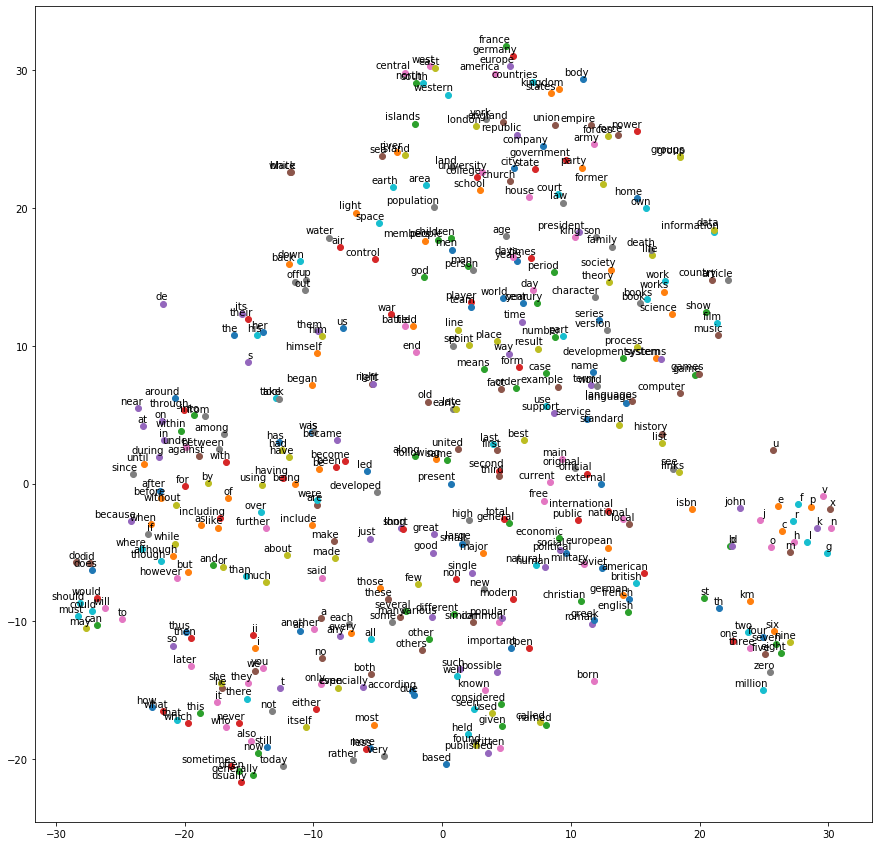

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [11]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index

    assert batch_size > 2 * bag_window + 1
    
    batch = np.ndarray(shape=(batch_size, 2 * bag_window), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * bag_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size):
        target = bag_window
        k = 0
        for j in range(span):
            if j != target:
                batch[i, k] = buffer[j]
                k += 1
        labels[i, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[bi2] for bi2 in bi1] for bi1 in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [12]:
rv = tf.ones([4,2,4], tf.int32)

#initialize the variable
init_op = tf.global_variables_initializer()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    print (tf.shape(rv))
    print (sess.run(rv))   
    
    rvs = tf.reduce_sum(rv, 1)
    
    print (tf.shape(rvs))
    print (sess.run(rvs))    

Tensor("Shape:0", shape=(3,), dtype=int32)
[[[1 1 1 1]
  [1 1 1 1]]

 [[1 1 1 1]
  [1 1 1 1]]

 [[1 1 1 1]
  [1 1 1 1]]

 [[1 1 1 1]
  [1 1 1 1]]]
Tensor("Shape_1:0", shape=(2,), dtype=int32)
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]


In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.

bag_window = 1

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  with tf.name_scope('input'): 
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * bag_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  with tf.name_scope('layers'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed0 = tf.nn.embedding_lookup(embeddings, train_dataset)
  embed = tf.reduce_sum(embed0, 1)

  # Compute the softmax loss, using a sample of the negative labels each time.
  with tf.name_scope('loss'): 
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  with tf.name_scope('train'):
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(tf.cast(valid_embeddings, tf.float32), tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001
loss_cbow = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      loss_cbow.append(average_loss)  
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.375203
Nearest to between: presentation, danville, moron, hawick, devo, exerted, dramatised, wanderings,
Nearest to only: kilobit, harbin, banting, tories, modal, presaged, florentines, icrc,
Nearest to also: realisation, ladders, forecasting, logographic, lieu, coru, punishment, strangely,
Nearest to six: benz, remixing, kolbe, consultation, affiliate, dutt, germinal, tsang,
Nearest to five: mmx, recourse, epistles, dalton, bibles, dissonance, ambients, seizures,
Nearest to i: stanhope, illuminating, realizing, daredevil, disintegration, reynard, clg, laborer,
Nearest to zero: superstitious, flaubert, sceptre, raft, importance, elwood, bihar, snowfall,
Nearest to three: cyanide, snowball, bilingual, anderson, clipperton, ghanaian, kzinti, handily,
Nearest to first: idaho, alcuin, farsi, tibeto, kvac, antiaircraft, snake, dissipation,
Nearest to one: manage, reasonably, wes, caprino, lump, fbi, downfall, chaldeans,
Nearest to were: oeuvres, industr

Average loss at step 52000: 2.889008
Average loss at step 54000: 2.867542
Average loss at step 56000: 2.858797
Average loss at step 58000: 2.750398
Average loss at step 60000: 2.830648
Nearest to between: among, with, within, through, into, slugger, nuisance, tiptree,
Nearest to only: either, generally, actually, happen, ebcdic, readily, all, until,
Nearest to also: often, now, actually, sometimes, typically, still, never, usually,
Nearest to six: seven, five, four, eight, nine, three, two, zero,
Nearest to five: six, seven, four, eight, three, nine, zero, two,
Nearest to i: we, you, ii, sor, reggaeton, yearning, vanquish, log,
Nearest to zero: seven, five, six, four, eight, nine, three, two,
Nearest to three: four, six, five, two, seven, eight, nine, zero,
Nearest to first: last, second, next, third, final, original, best, fourth,
Nearest to one: two, seven, six, four, eight, five, three, nine,
Nearest to were: are, had, was, have, those, been, including, include,
Nearest to when: if,

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

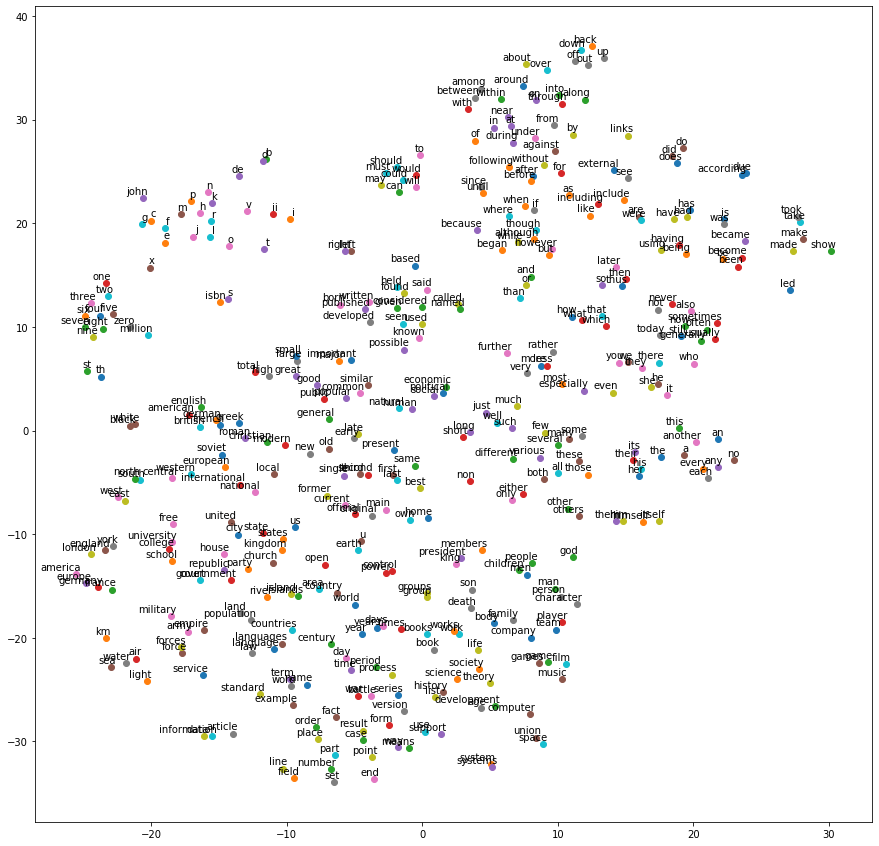

In [16]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

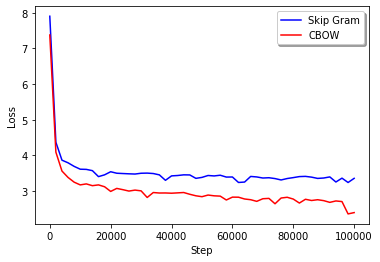

In [17]:
import matplotlib.pyplot as plt

def plot_results(steps, loss_skip_gram, loss_cbow):
  fig, ax = plt.subplots()
  ax.plot(steps, loss_skip_gram, 'b', label="Skip Gram")
  ax.plot(steps, loss_cbow, 'r', label="CBOW")
  ax.legend(loc='upper right', shadow=True)
  plt.xlabel('Step')
  plt.ylabel('Loss')
  plt.show()

steps = range(0, num_steps, 2000)
plot_results(steps, loss_skip_gram, loss_cbow)